In [23]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
import xgboost
from xgboost import XGBRegressor,XGBClassifier
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from sklearn.metrics import mean_squared_error


import pydotplus
from IPython.display import display, Image

# Regression

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
Y = boston.target

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 20)

## Cart

In [30]:
clf = DecisionTreeRegressor(max_depth = 3)
clf = clf.fit(x_train,y_train)

y_pred = clf.predict(x_test)
mean_squared_error(y_test, y_pred)

36.74332304920764

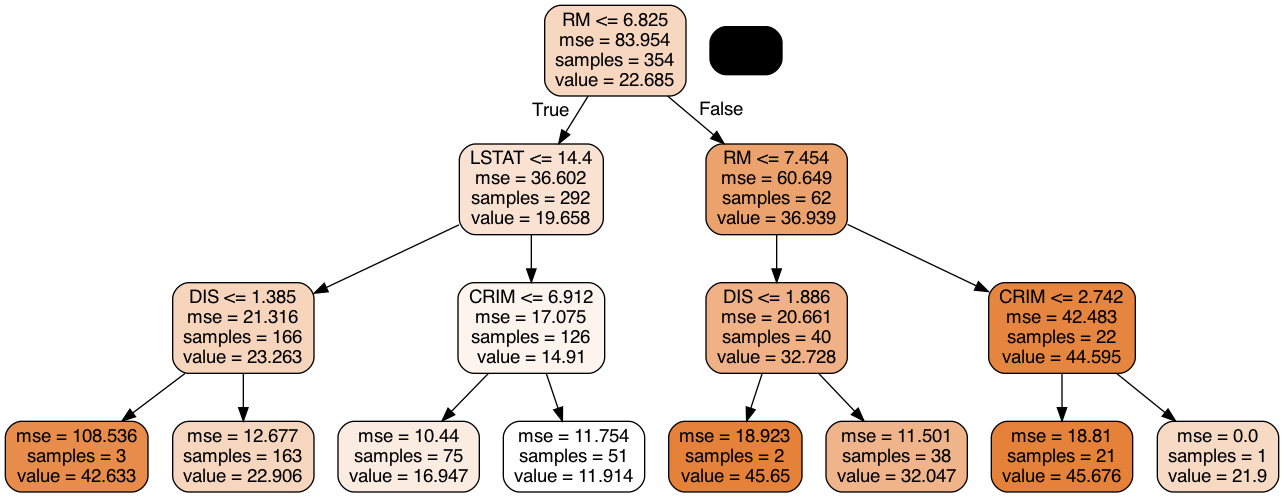

In [19]:
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=x_train.columns, #the 1st line in each box
                                filled = True,
                                rounded =True
                               )

graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

Samples indicates the number of observations (i.e. rows) 
and value shows the distribution of these samples according to the target variable.

## Random Forest

In [29]:
rf = RandomForestRegressor(random_state=10,n_estimators = 1000,n_jobs= -1) 
 #n_estimators, default=100,The number of trees in the forest.
 #n_jobs, default=None. The number of jobs to run in parallel. -1 means using all processors.
 #random_state, Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node.
    
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)
mean_squared_error(y_test, y_pred)

25.746221089671042

## GBDT

In [13]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000]}    

gbdtRegressor = GradientBoostingRegressor()

gbdt = GridSearchCV(estimator = gbdtRegressor, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

gbdt.fit(x_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error', verbose=1)

In [15]:
y_pred = gbdt.predict(x_test)
mean_squared_error(y_test, y_pred)

13.151871956940413

In [16]:
gbdt.best_params_

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}

## XGBoost

In [21]:
xgb = XGBRegressor(objective='reg:squarederror')
    #reg:squarederror: for linear regression. Default.
    #more: https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}  

clf = RandomizedSearchCV(estimator=xgb, 
                       param_distributions=params,
                       scoring='neg_mean_squared_error', 
                       n_iter=25,
                       verbose=1)

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
mean_squared_error(y_test, y_pred)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


13.932306779333981

In [22]:
clf.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 500,
 'max_depth': 6,
 'learning_rate': 0.2,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.4}

## LightGBM

In [ ]:
lgb_train = lgb.Dataset(x_train, y_train) # 将数据保存到LightGBM二进制文件将使加载更快
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)  # 创建验证数据


params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # 设置提升类型
    'objective': 'regression', # 目标函数
    'metric': {'l2', 'auc'},  # 评估函数
    'num_leaves': 31,   # 叶子节点数
    'learning_rate': 0.05,  # 学习速率
    'feature_fraction': 0.9, # 建树的特征选择比例
    'bagging_fraction': 0.8, # 建树的样本采样比例
    'bagging_freq': 5,  # k 意味着每 k 次迭代执行bagging
    'verbose': 1 # <0 显示致命的, =0 显示错误 (警告), >0 显示信息
}
 
print('Start training...')
# 训练 cv and train
gbm = lgb.train(params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=5) # 训练数据需要参数列表和数据集
 
#print('Save model...') 
#gbm.save_model('model.txt')   # 训练后保存模型到文件
 
print('Start predicting...')
# 预测数据集
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration) #如果在训练期间启用了早期停止，可以通过best_iteration方式从最佳迭代中获得预测
# 评估模型
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5) # 计算真实值和预测值之间的均方根误差


# Classification

In [25]:
data = pd.read_csv('./Classification/train_dp.csv')
Y = data['survived']
X = data.drop(columns = ['survived'])

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state = 20)

## Cart

In [26]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4)
clf = clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.84%


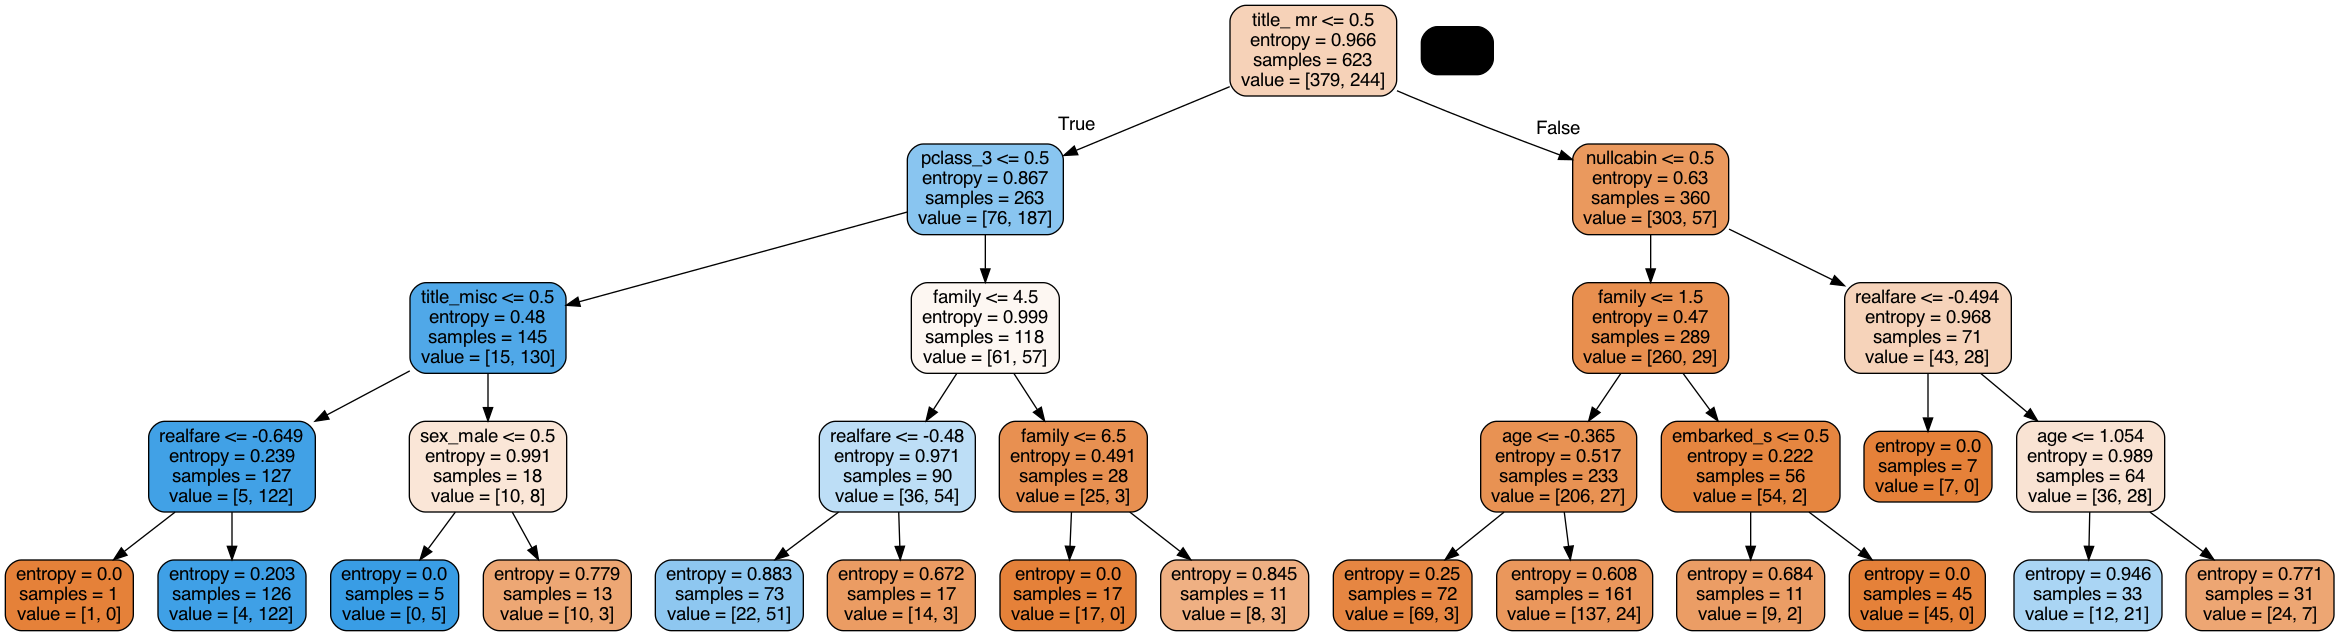

In [27]:
dot_data = tree.export_graphviz(clf, 
                                out_file=None, 
                                feature_names=x_train.columns, #the 1st line in each box
                                filled = True,
                                rounded =True
                               )

graph = pydotplus.graph_from_dot_data(dot_data)
display(Image(graph.create_png()))

## RF

In [46]:
rf = RandomForestClassifier(random_state=10,n_estimators = 1000,n_jobs= -1) 
 #n_estimators, default=100,The number of trees in the forest.
 #n_jobs, default=None. The number of jobs to run in parallel. -1 means using all processors.
 #random_state, Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node.
    
rf.fit(x_train,y_train)

y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.49%


## GBDT

In [51]:
gbdt = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)
gbdt.fit(x_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbdt.staged_predict(x_test)]
best_n_estimators = np.argmin(errors)
best_n_estimators

2

In [53]:
gbdt_best = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=best_n_estimators,
    learning_rate=1.0
)
gbdt_best.fit(x_train, y_train)

y_pred = gbdt_best.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 82.84%


## XGBoost

In [42]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.24%
